In [1]:
import glob
import scipy
import os,sys
import zipfile
import numpy as np
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
from tensorflow import keras
from natsort import natsorted
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from aifnet_utils.preprocess import read_nifti_file, normalize, normalize_aif, process_scan, normalize_zero_one
from aifnet_utils.data_loaders import read_isles_volumepaths_from_file_otf, read_isles_annotations_from_file, ISLES18DataGen_aifvof_otf
from aifnet_utils.data_loaders import delay_sequence_padding, anticipate_sequence_padding, late_bolus, early_bolus
from aifnet_utils.results import plot_predictions
from aifnet_utils.losses import MaxCorrelation
from scipy import signal
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from scipy.linalg import convolution_matrix, toeplitz, circulant
from sklearn.linear_model import Ridge
from matplotlib import pyplot, image, transforms
from scipy import ndimage
from aifnet_utils.models_aifnet import get_model_twoPvols, get_model_onehead
from numpy import inf
from aifnet_utils.results import plot_predictions

import random
keras.backend.set_image_data_format('channels_last')

%matplotlib inline
!pwd

/home/sebastian/experiments/aifnet_replication


In [14]:
#Reading an example PCT volume
LOCATION = 'INSEL'
if LOCATION == 'LOCAL':
    ROOT_EXP = '/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication/'
    root_dir  = '/Users/sebastianotalora/work/postdoc/data/ISLES/'

if LOCATION == 'INSEL':
    ROOT_EXP = '/home/sebastian/experiments/aifnet_replication/'
    root_dir  = '/media/sebastian/data/ASAP/ISLES2018_Training'

aif_annotations_path = ROOT_EXP + 'radiologist_annotations_cleaned.csv'

In [15]:
min_num_volumes_ctp = 43

In [21]:
def compute_predictions_aif(model_prefix):
    model_prefix_meassures = []
    for current_fold in range(1,6):
        prediction_meassures = []
        correlations_fold = []
        #Reading AIFs and VOFs for each of the partitions
        test_partition_path =  ROOT_EXP+'/partitions/fold_'+str(current_fold) +'/test_v2.txt'

        aif_annotations_test, vof_annotations_test = read_isles_annotations_from_file(aif_annotations_path,  test_partition_path,
                                                root_dir, min_num_volumes_ctp, return_aif_only = False)
        ctp_volumes_test = read_isles_volumepaths_from_file_otf(root_dir, test_partition_path, aif_annotations_path)
        print('======= PREDICTING USING '+ model_prefix +' FOR TEST PARTITION FOR THE FOLD ' + str(current_fold) + ' =======')
        print(len(ctp_volumes_test), len(aif_annotations_test))
        modelweights_path= ROOT_EXP + 'results/results_server/'+ model_prefix+'_fold_'+str(current_fold)+'.hdf5'
        model = get_model_onehead(width=256, height=256, num_channels=min_num_volumes_ctp)
        model.load_weights(modelweights_path)
        results_meassures, prediction_ids = [], []
        for case_number in range(len(ctp_volumes_test)):
            case_id = ctp_volumes_test[case_number]['image'].split('.')[-2]
            prediction_ids.append(case_id)
            cur_nib = nib.load(ctp_volumes_test[case_number]['image'])
            ctp_vals = cur_nib.get_fdata()
            x = normalize(ctp_vals[:,:,:,0:min_num_volumes_ctp])
            if type_predictions == 'AIF':
                y = aif_annotations_test[case_id]
            if type_predictions == 'VOF':
                y = vof_annotations_test[case_id]
            prefix_fig = ROOT_EXP + '/results/predictions_aif/'+modelweights_path.split('/')[-1]+'_case_'+str(case_id) + '_'+type_predictions
            y,y_hat = plot_predictions(model,x,y, prefix_fig, normalize_preds=True, type_pred=type_predictions, savefig=False)
            correlations_fold.append(pearson_corr(y,y_hat))
            #correlations_fold.append(person_corr(np.array(results_meassures)[:,1],np.array(results_meassures)[:,0]))
        #preds_fold = preds_fold.numpy()
        correlations_fold = np.array(correlations_fold)
        prediction_meassures.append([correlations_fold.mean(),correlations_fold.std(),correlations_fold.var()])
        model_prefix_meassures.append(prediction_meassures)
        np.savetxt('results/'+model_prefix+'pearson_fold_'+str(current_fold)+'.csv', prediction_meassures[-1], delimiter=',',fmt='%1.5f')
        #np.savetxt('results/'+model_prefix+'allpreds_fold_'+str(current_fold)+'.csv', np.array(results_meassures)[:,1,:], delimiter=',',fmt='%1.5f')

        #test_ids_file=open('results/'+model_prefix+'pred_ids_fold_'+str(current_fold)+'.csv','w')
        #for element in prediction_ids:        
        #    test_ids_file.write(element+'\n')
        #test_ids_file.close()
    model_prefix_meassures = np.array(model_prefix_meassures)
    np.savetxt('results/'+model_prefix+'pearson_ALLFOLDS.csv', model_prefix_meassures.mean(axis=0), delimiter=',',fmt='%1.5f')
    return model_prefix_meassures.mean(axis=0)

In [17]:
last_trained_model_paths = glob.glob('/home/sebastian/experiments/aifnet_replication/results/results_server/*')
last_prefixes = []
for item in last_trained_model_paths:
    prefix_path = item.split('/')[-1].split('_fold')[0]
    if prefix_path not in set(last_prefixes):
        last_prefixes.append(prefix_path)
print(len(last_prefixes))
print(len(last_trained_model_paths))

18
78


In [18]:
def pearson_corr(y,y_hat):
    pearson_numerator = np.sum((y-np.average(y))*(y_hat-np.average(y_hat)))
    pearson_denominator = np.sqrt(np.sum(np.square(y-np.average(y)))) *np.sqrt(np.sum(np.square(y_hat-np.average(y_hat))))
    pearson_correlation = np.abs(pearson_numerator/pearson_denominator)
    return pearson_correlation

In [19]:
type_predictions = 'AIF'
all_results = []
for model_prefix in last_prefixes:
    #print(compute_predictions_aif(model_prefix))
    results_meassures = compute_predictions_aif(model_prefix)
    all_results.append(results_meassures)

======= PREDICTING USING aifnet_SGD_MSE_augment_lr0.21397559111171494 FOR TEST PARTITION FOR THE FOLD 1 =======
31 31
======= PREDICTING USING aifnet_SGD_MSE_augment_lr0.21397559111171494 FOR TEST PARTITION FOR THE FOLD 2 =======
29 29
======= PREDICTING USING aifnet_SGD_MSE_augment_lr0.21397559111171494 FOR TEST PARTITION FOR THE FOLD 3 =======
32 32
======= PREDICTING USING aifnet_SGD_MSE_augment_lr0.21397559111171494 FOR TEST PARTITION FOR THE FOLD 4 =======
34 34
======= PREDICTING USING aifnet_SGD_MSE_augment_lr0.21397559111171494 FOR TEST PARTITION FOR THE FOLD 5 =======
28 28
======= PREDICTING USING aifnet_SGD_MSE_augment_lr0.00492391140812807 FOR TEST PARTITION FOR THE FOLD 1 =======
31 31
======= PREDICTING USING aifnet_SGD_MSE_augment_lr0.00492391140812807 FOR TEST PARTITION FOR THE FOLD 2 =======
29 29
======= PREDICTING USING aifnet_SGD_MSE_augment_lr0.00492391140812807 FOR TEST PARTITION FOR THE FOLD 3 =======
32 32
======= PREDICTING USING aifnet_SGD_MSE_augment_lr0.0049

OSError: Unable to open file (unable to open file: name = '/home/sebastian/experiments/aifnet_replication/results/results_server/predictions_aif_fold_1.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [18]:
modelweights_path= ROOT_EXP + 'results/trained_models/aifnet_SGD_MAXCORR_augment_lr/'+ model_prefix+'_fold_'+str(1)+'.hdf5'
model = get_model_onehead(width=256, height=256, num_channels=min_num_volumes_ctp)
model.load_weights(modelweights_path)
y = np.ones(43)
prefix_fig = ROOT_EXP + '/results/predictions_aif/'+modelweights_path.split('/')[-1]+'_case_'+str(1) + '_'+'AIF'

o1,o2 = plot_predictions(model,np.random.rand(256,256,5,43),y, prefix_fig, normalize_preds=True, type_pred=type_predictions, savefig=True)

OSError: Unable to open file (unable to open file: name = '/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication/results/trained_models/aifnet_SGD_MAXCORR_augment_lr/aifnet_SGD_MSE_augment_lr0.21397559111171494_fold_1.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

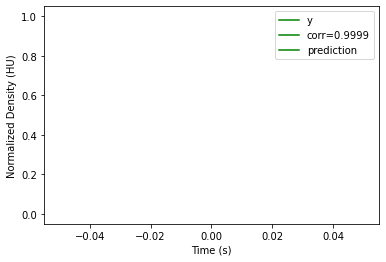

In [31]:
sample_pred = 0
y = o2#results_meassures[sample_pred][0]
y_hat = o2#results_meassures[sample_pred][1][0,:]

pearson_numerator = np.sum((y-np.average(y))*(y_hat-np.average(y_hat)))
pearson_denominator = np.sqrt(np.sum(np.square(y-np.average(y)))) *np.sqrt(np.sum(np.square(y_hat-np.average(y_hat))))
pearson_correlation = pearson_numerator/pearson_denominator

plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')

plt.plot(y,'g-')
plt.plot(y_hat,'w-')
plt.plot(y_hat,'b-')
plt.legend(['y', 'corr='+str(pearson_correlation)[0:6] , 'prediction'])
plt.savefig('corr_0.7.svg',format='svg')




In [19]:
MaxCorrelation(np.array(y,dtype='float64'),np.array(y_hat,dtype='float64'))

NameError: name 'y' is not defined

In [20]:
correlations_batch = []
for sample_pred in range(len(results_meassures)):
    y = results_meassures[sample_pred][0]
    y_hat = results_meassures[sample_pred][1][0]
    pearson_numerator = np.sum((y-np.average(y))*(y_hat-np.average(y_hat)))
    pearson_denominator = np.sqrt(np.sum(np.square(y-np.average(y)))) *np.sqrt(np.sum(np.square(y_hat-np.average(y_hat))))
    pearson_correlation = np.abs(pearson_numerator/pearson_denominator)
    correlations_batch.append(pearson_correlation)
    print(pearson_correlation)

NameError: name 'results_meassures' is not defined

In [173]:
np.mean(correlations_batch)

0.6913478341315272

In [ ]:
corrs = [0.691347,correlations_batch,0,0,0]